## 0. Import libraries and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [2]:
data = pd.read_csv('Walmart_Store_sales.csv')
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


## 1. EDA
### 1.1 Basic statistics

In [3]:
print(f'The dataset contains {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset contains 150 rows and 8 columns.


In [4]:
data.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


All columns except *Store* contains missing data. The max percentage of missing values being 12% and the number of features for our model being quite small, we will try not to drop any columns and find the best way to impute these missing values. 

However, we will drop rows with missing *Weekly_Sales* as it is our target variable and we don't want introduce any biais in our model predictions by imputing these data. 

In [5]:
print("Percentage of missing values: ")
round(100*data.isnull().sum()/data.shape[0] ,2).sort_values(ascending=False)

Percentage of missing values: 


Date            12.00
Temperature     12.00
Unemployment    10.00
Weekly_Sales     9.33
Fuel_Price       9.33
Holiday_Flag     8.00
CPI              8.00
Store            0.00
dtype: float64

Let's go through each of our features to identify what processing tasks will need to be done

### 1.2 Categorical variables
#### 1.2.1 Store

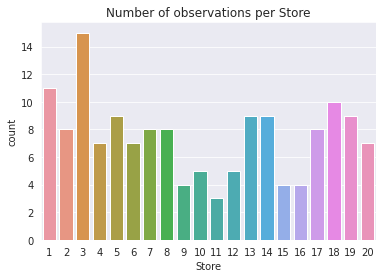

In [6]:
sns.countplot(x=data['Store'].astype('int')).set(title='Number of observations per Store');

#### 1.2.2 Date
*Date* is not really a categorical variable as it can not be used in its current state by the model. We will later create some features from it (extract day, month etc.) but first we need to investigate the missing data and try to find out a way to impute them.
First let's convert the column into datetime

In [7]:
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

In [8]:
print(f'The first date of dataset is {data["Date"].min()} and the last date is {data["Date"].max()}')
print(f'There are {data["Date"].isnull().sum()} rows with a missing date')

The first date of dataset is 2010-02-05 00:00:00 and the last date is 2012-10-19 00:00:00
There are 18 rows with a missing date


The following plot shows the distribution overtime of our data. We can see that there seems to be more data in 2010, as well as the summer months

<AxesSubplot:xlabel='count', ylabel='Date'>

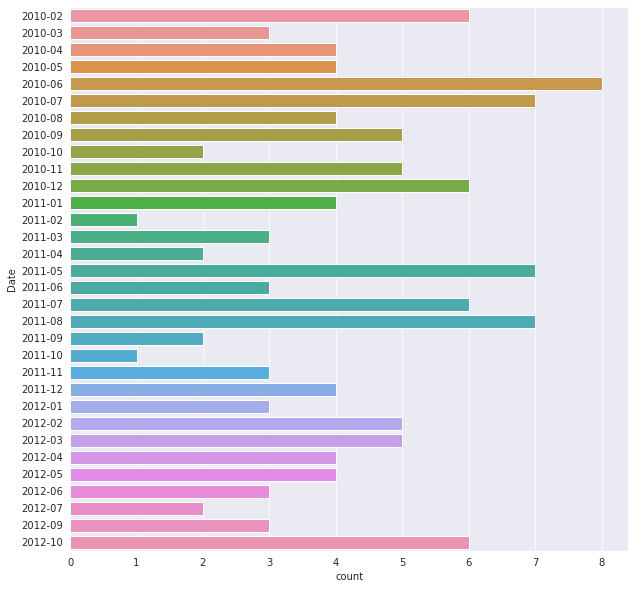

In [9]:
plt.figure(figsize=(10, 10))
sns.countplot(y=data['Date'].dt.to_period('M').sort_values())

Let's get into more details. We will create new columns :

In [71]:
data['year'] = data['Date'].dt.year.astype('Int64')
data['month'] = data['Date'].dt.month.astype('Int64')
data['day'] = data['Date'].dt.day.astype('Int64')
data['dayofyear'] = data['Date'].dt.dayofyear.astype('Int64')
data['week'] = data['Date'].dt.week.astype('Int64')
data['dayofweek'] = data['Date'].dt.dayofweek.astype('Int64')
data.head()

/tmp/ipykernel_90/1774895216.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['week'] = data['Date'].dt.week.astype('Int64')


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,dayofweek,fuel_price_outlier,CPI_outlier,Unemployment_outlier
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,49,7,4,False,False,False
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,84,12,4,False,False,False
2,17.0,2012-07-27,NaN,0.0,NaN,NaN,130.719581,5.936,2012,7,27,209,30,4,NaN,False,False
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,False,False
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,148,21,4,False,False,False


Based on the following plots, here are some ideas for imputing missing data :
1. YEAR -> Replace with the most frequent value, ie 2010
2. MONTH -> May, June and July are the most represented months. Replace missing month by a random choice between tese 3 months.
3. DAY -> Drop the column as we are working with data that are aggreated weekly so it does not make sense to keep it 
4. DAY OF YEAR -> Same as above, drop the column
5. WEEK OF YEAR --> Replace with median
6. DAY OF WEEK -> Drop the column. It's always Friday so it does not add any value

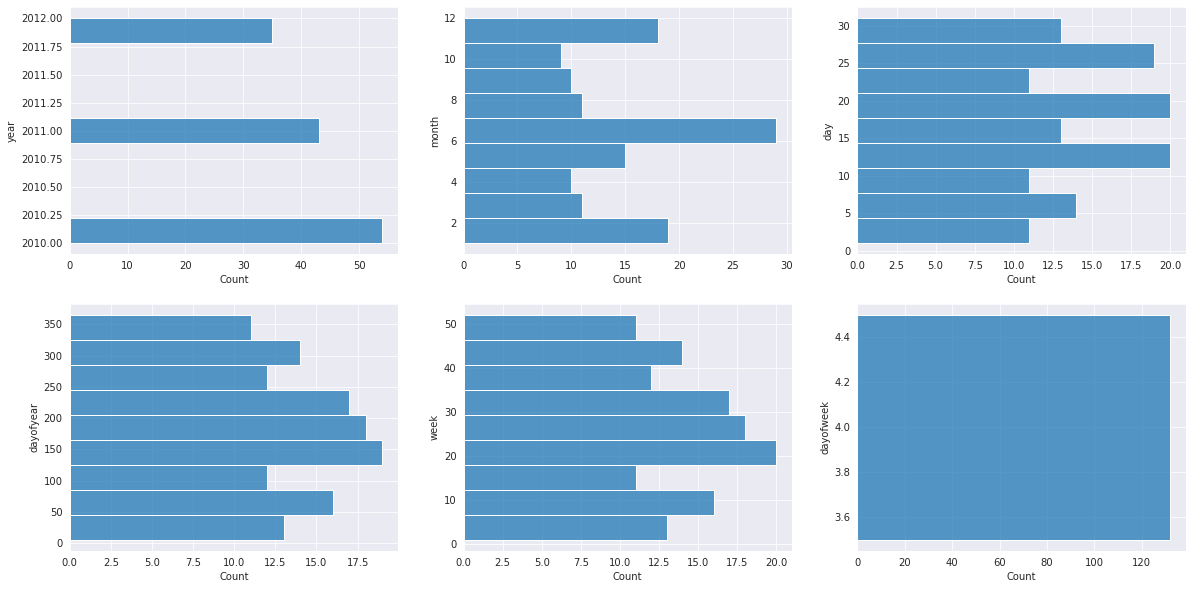

In [62]:
n_rows=2
n_cols=3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
for i, column in enumerate(data.iloc[:,-6:]):
    g = sns.histplot(y=data[column].sort_values(), ax=axes[i // n_cols, i % n_cols], stat='count')

In [66]:
data['month'].value_counts()

7     15
5     15
6     14
2     12
3     11
8     11
12    10
4     10
9     10
10     9
11     8
1      7
Name: month, dtype: Int64

#### 1.2.2 Holiday Flag

As expected, most the records have the Holiday Falg set to 0. We can therefore impute the missing value with **0**.

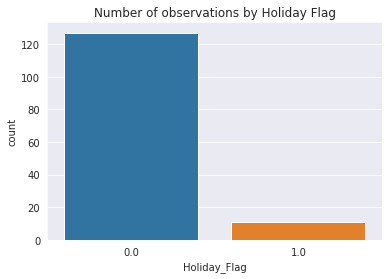

In [69]:
sns.countplot(x=data['Holiday_Flag']).set(title='Number of observations by Holiday Flag');

### 1.3 Quantitative variables
#### 1.3.1 Temperatures

In [112]:
print(f'The first date of dataset is {data["Temperature"].min()} and the last date is {data["Temperature"].max()}')
print(f'There are {data["Temperature"].isnull().sum()} rows with a missing date')

The first date of dataset is 18.79 and the last date is 91.65
There are 18 rows with a missing date


In [92]:
data['Temperature'].describe()

count    132.000000
mean      61.398106
std       18.378901
min       18.790000
25%       45.587500
50%       62.985000
75%       76.345000
max       91.650000
Name: Temperature, dtype: float64

##### 1.3.1.1 Outliers

Looking at the boxplot, there does to not seem to have any outliers for these features. We will still calculate if the data falls within  $[\bar{X} - 3\sigma, \bar{X} + 3\sigma]$

<AxesSubplot:xlabel='Temperature'>

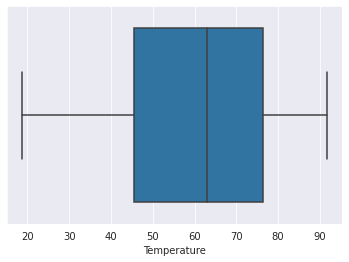

In [89]:
sns.boxplot(x=data['Temperature'])

In [12]:
# Function that we will reuse for the other features
import numpy as np
def is_outlier(value, data):
    mean = np.mean(data)
    std = np.std(data)
    if (mean - 3*std) <= value <= (mean + 3*std):
        return False
    else:
        return True
    

In [102]:
data['temperature_outlier'] = data['Temperature'].apply(lambda x : is_outlier(x, data['Temperature']) if not np.isnan(x) else x )

We can confirm there no outliers to drop for the Temperature feature.

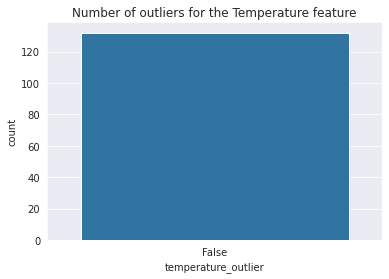

In [105]:
sns.countplot(x=data['temperature_outlier']).set(title='Number of outliers for the Temperature feature');

##### 1.3.1.2 Missing values
As expected there is a high corroletation between the month of the year of the temperature. We will impute missing data by the mean of the temprature of the observation month. We could also do the opposite and use the temperature to impute the missing dates !

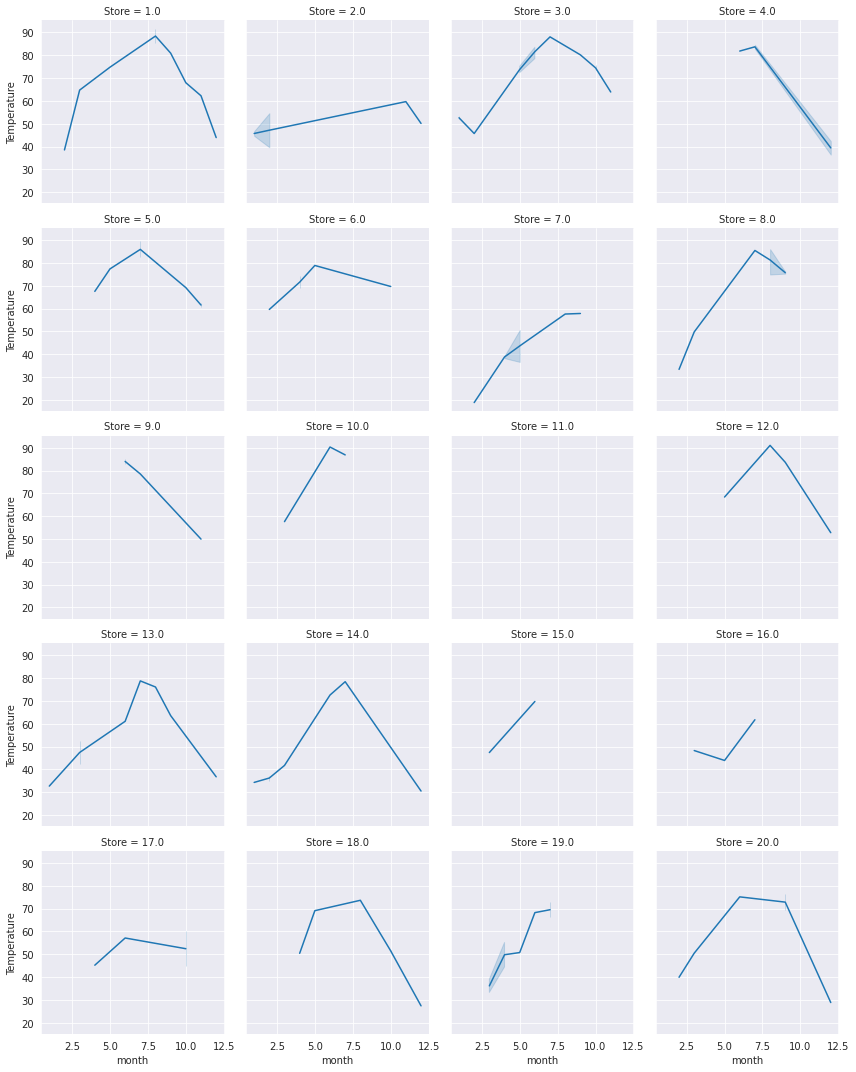

In [58]:
g = sns.FacetGrid(data, col='Store', col_wrap=4)
g.map(sns.lineplot, 'month', 'Temperature')

<AxesSubplot:xlabel='month', ylabel='Temperature'>

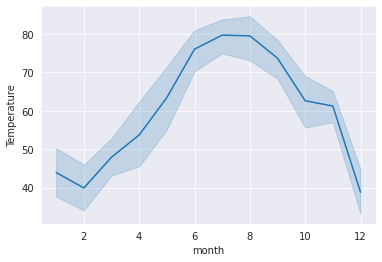

In [108]:
sns.lineplot(data=data, x='month', y='Temperature')

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

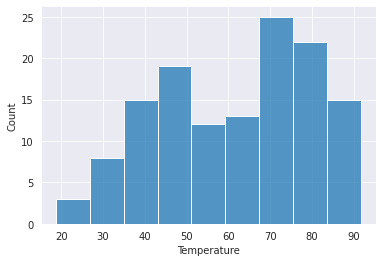

In [146]:
sns.histplot(x=data['Temperature'])

In [151]:
data.groupby(by=['month', 'year'])['Fuel_Price'].mean()

month  year
1      2011    3.031250
       2012    3.261000
2      2010    2.618200
       2011    3.045000
       2012    3.492500
3      2010    2.908500
       2011    3.616333
       2012    3.783200
4      2010    2.806667
       2011    3.815000
       2012    4.079000
5      2010    2.818750
       2011    3.943714
       2012    3.811500
6      2010    2.723000
       2011    3.819500
       2012    3.618667
7      2010    2.762429
       2011    3.645167
       2012    3.666000
8      2010    2.720000
       2011    3.598714
9      2010    2.734333
       2011    3.557500
       2012    3.722000
10     2010    2.865500
       2011    3.285000
       2012    3.700333
11     2010    2.766250
       2011    3.304333
12     2010    3.056667
       2011    3.145333
Name: Fuel_Price, dtype: float64

#### 1.3.2 Fuel Price

In [115]:
data['Fuel_Price'].describe()

count    136.000000
mean       3.320853
std        0.478149
min        2.514000
25%        2.852250
50%        3.451000
75%        3.706250
max        4.193000
Name: Fuel_Price, dtype: float64

In [114]:
print(f'There are {data["Fuel_Price"].isnull().sum()} rows with a missing Fuel Price')

There are 14 rows with a missing Fuel Price


##### 1.3.2.1 Outliers

In [13]:
data['fuel_price_outlier'] = data['Fuel_Price'].apply(lambda x : is_outlier(x, data['Fuel_Price']) if not np.isnan(x) else x )

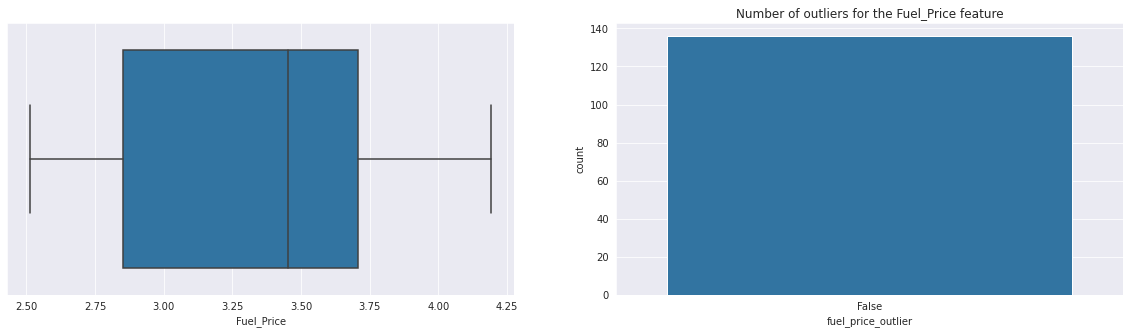

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(x=data['Fuel_Price'], ax=axes[0])
sns.countplot(x=data['fuel_price_outlier'], ax=axes[1]).set(title='Number of outliers for the Fuel_Price feature');

There are no outliers for this feature

##### 1.3.2.2 Missing data

The standard deviation being low. We could potentially replace the missing data by the mean 

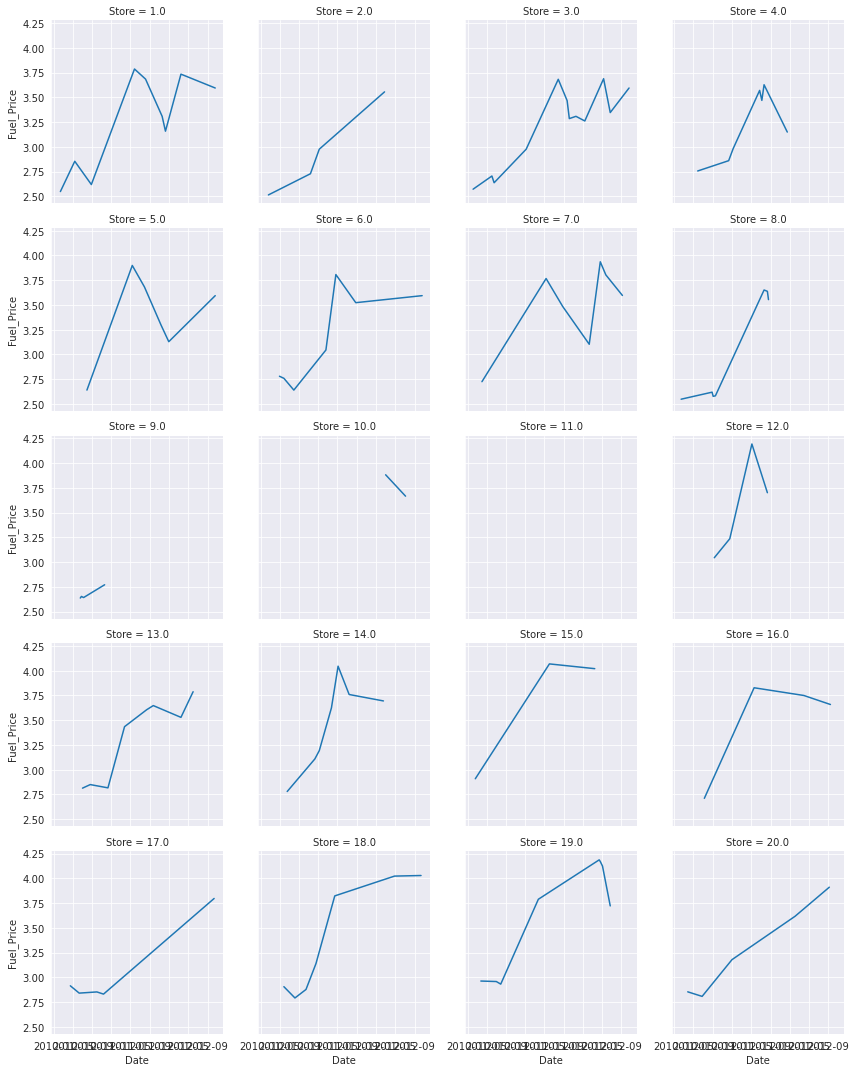

In [57]:
g = sns.FacetGrid(data, col='Store', col_wrap=4)
g.map(sns.lineplot, 'Date', 'Fuel_Price')

The fuel price does not seem to be different for different stores

<AxesSubplot:xlabel='Date', ylabel='Fuel_Price'>

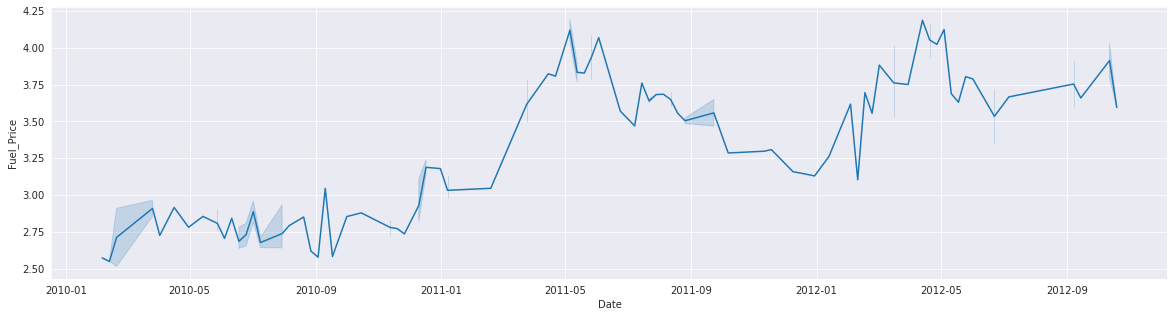

In [50]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='Date', y='Fuel_Price')

<AxesSubplot:xlabel='Date', ylabel='Fuel_Price'>

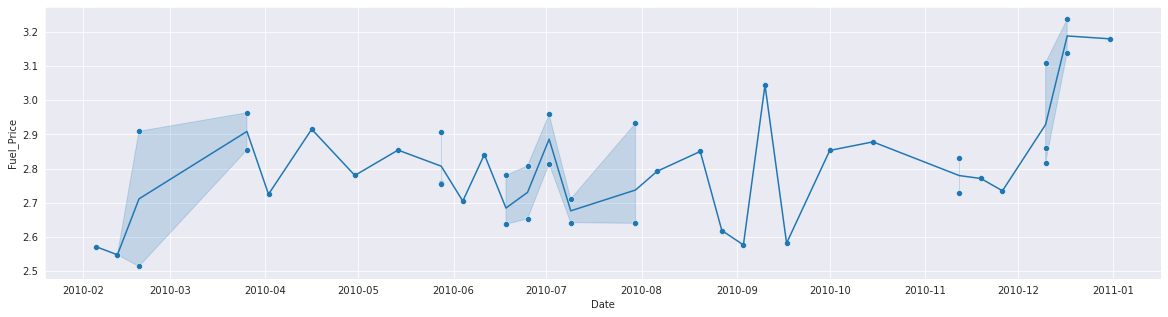

In [140]:
fig, ax = plt.subplots(1,1,figsize=(20, 5))

sns.lineplot(data=data[data['year'] == 2010], x='Date', y='Fuel_Price', ax=ax)
sns.scatterplot(data=data[data['year'] == 2010], x='Date', y='Fuel_Price', ax=ax)

In [144]:
data[data["Fuel_Price"].isnull() & data["Date"].isnull()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,dayofweek,temperature_outlier
3,11.0,NaT,1244390.03,0.0,84.57,NaN,214.556497,7.346,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False


The standard deviation might be low, however we can see that the fuel price fluctuates a lot. Over the span of our dataset, we can clearly see an upwards trend. Only one record has a missing date and fuel price. Therefore I suggess to try imputing the missing fuel price by the mean between the closest inferior and superior date. 

#### 1.3.3 CPI

In [18]:
data['CPI'].describe()

count    138.000000
mean     179.898509
std       40.274956
min      126.111903
25%      131.970831
50%      197.908893
75%      214.934616
max      226.968844
Name: CPI, dtype: float64

In [20]:
print(f'There are {data["CPI"].isnull().sum()} rows with a missing CPI')

There are 12 rows with a missing CPI


#### 1.3.3.1 Outliers

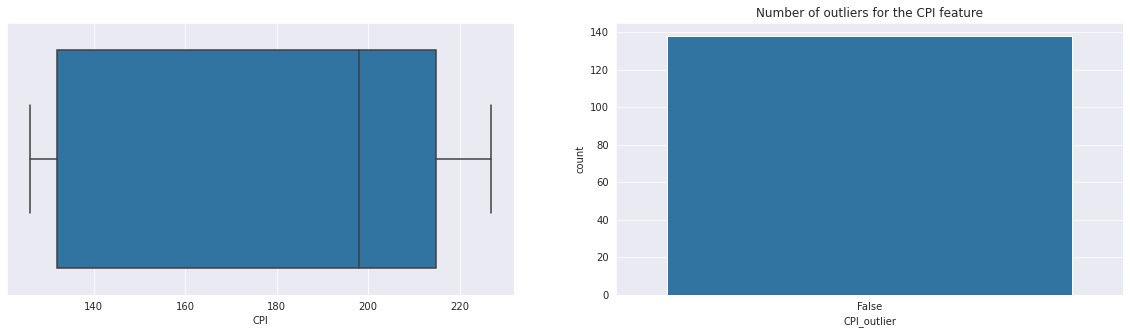

In [22]:
data['CPI_outlier'] = data['CPI'].apply(lambda x : is_outlier(x, data['CPI']) if not np.isnan(x) else x )
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(x=data['CPI'], ax=axes[0])
sns.countplot(x=data['CPI_outlier'], ax=axes[1]).set(title='Number of outliers for the CPI feature');

No outliers

#### 1.3.3.2 Missing data

<AxesSubplot:xlabel='CPI', ylabel='Count'>

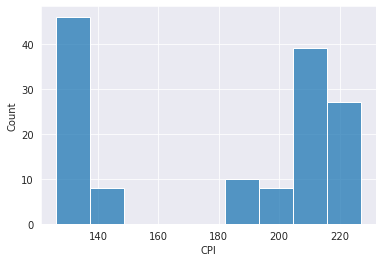

In [52]:
sns.histplot(x=data['CPI'])

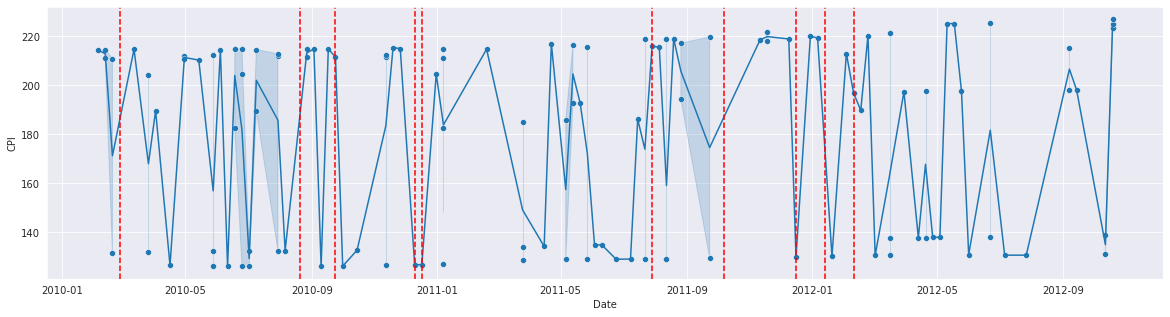

In [46]:
import datetime as dt

plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='Date', y='CPI')
sns.scatterplot(data=data, x='Date', y='CPI')
for index, date in data.loc[data["CPI"].isnull() & data["Date"].notnull(), 'Date'].items() :
    plt.axvline(date, color='red', linestyle='--')
    

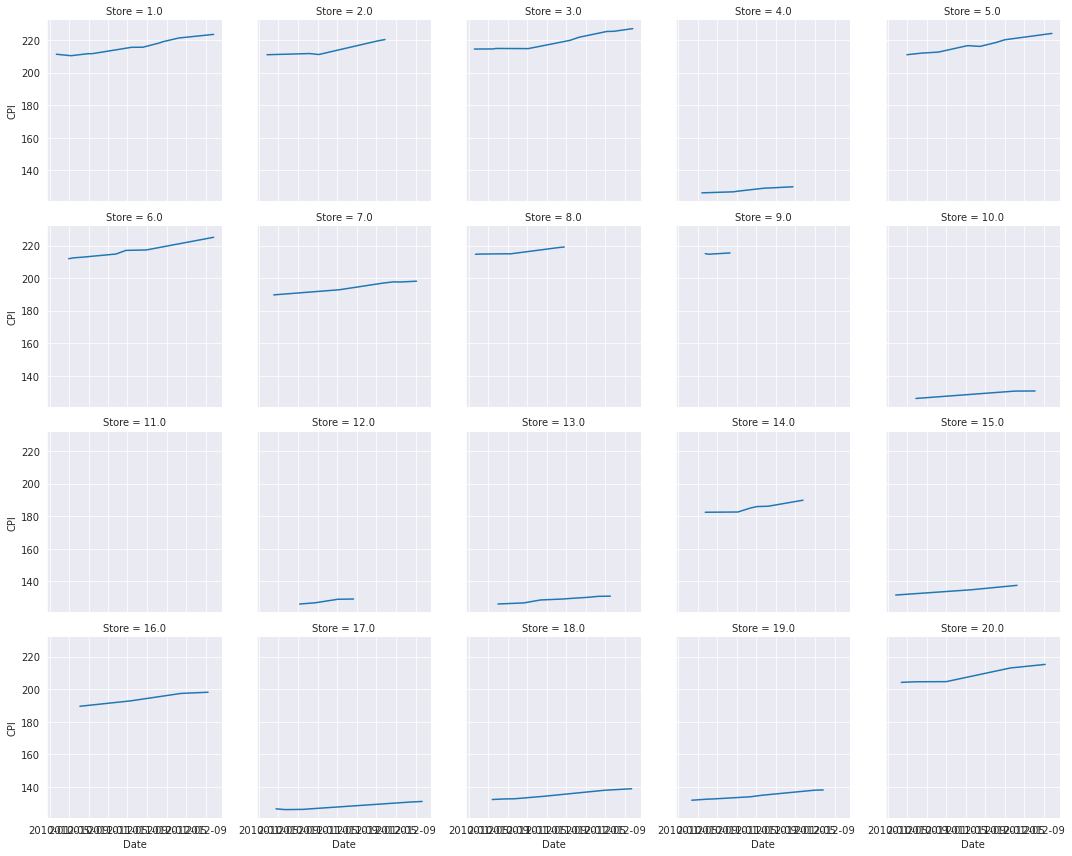

In [59]:
#sns.lineplot(data=data, x='Date', y='CPI', hue='Store')
g = sns.FacetGrid(data, col='Store', col_wrap=5)
g.map(sns.lineplot, 'Date', 'CPI')

The plots above shows are CPI is different for each Store. Overtime it is also slightly increasing. 
-> Imputing the missing data by the mean between the closest before and after date of the store.

#### 1.3.4 Unemployment
##### 1.3.4.1 Outliers

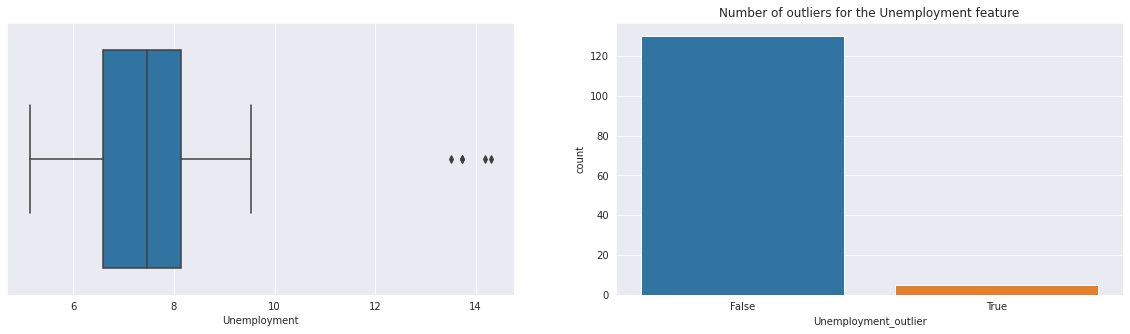

In [60]:
data['Unemployment_outlier'] = data['Unemployment'].apply(lambda x : is_outlier(x, data['Unemployment']) if not np.isnan(x) else x )
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(x=data['Unemployment'], ax=axes[0])
sns.countplot(x=data['Unemployment_outlier'], ax=axes[1]).set(title='Number of outliers for the Unemployment feature');

In [62]:
data[data['Unemployment_outlier'] == True]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,dayofweek,fuel_price_outlier,CPI_outlier,Unemployment_outlier
30,12.0,2011-05-06,1021154.48,0.0,68.40,4.193,129.044433,13.736,2011,5,6,126,18,4,False,False,True
62,12.0,2010-12-17,1295605.35,0.0,52.77,3.236,126.879484,14.313,2010,12,17,351,50,4,False,False,True
68,12.0,2011-08-12,955913.68,0.0,91.04,3.701,129.201581,13.503,2011,8,12,224,32,4,False,False,True
93,12.0,2011-05-27,964332.51,0.0,NaN,4.087,129.062355,13.736,2011,5,27,147,21,4,False,False,True
135,12.0,2010-09-10,903119.03,1.0,83.63,3.044,126.114581,14.180,2010,9,10,253,36,4,False,False,True


In [63]:
data[data['Store'] == 12.0]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,dayofyear,week,dayofweek,fuel_price_outlier,CPI_outlier,Unemployment_outlier
30,12.0,2011-05-06,1021154.48,0.0,68.40,4.193,129.044433,13.736,2011,5,6,126,18,4,False,False,True
62,12.0,2010-12-17,1295605.35,0.0,52.77,3.236,126.879484,14.313,2010,12,17,351,50,4,False,False,True
68,12.0,2011-08-12,955913.68,0.0,91.04,3.701,129.201581,13.503,2011,8,12,224,32,4,False,False,True
93,12.0,2011-05-27,964332.51,0.0,NaN,4.087,129.062355,13.736,2011,5,27,147,21,4,False,False,True
135,12.0,2010-09-10,903119.03,1.0,83.63,3.044,126.114581,14.180,2010,9,10,253,36,4,False,False,True


We found 5 outliers but when we look at it more closely, we realise that the 5 outliers are all the records for the Store 12. It might suggest that this specific store is located in a poorer area than the others. The CPI for this store is also low. 
I suggest not deleting this outliers and see how the model perform.

##### 1.3.4.1 Missing data

In [65]:
print(f'There are {data["Unemployment"].isnull().sum()} rows with a missing Unemployment')

There are 15 rows with a missing Unemployment


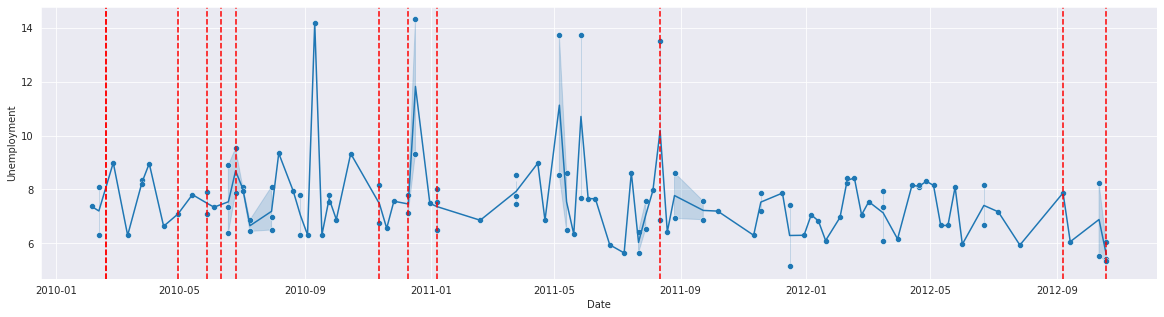

In [66]:
import datetime as dt

plt.figure(figsize=(20, 5))
sns.lineplot(data=data, x='Date', y='Unemployment')
sns.scatterplot(data=data, x='Date', y='Unemployment')
for index, date in data.loc[data["Unemployment"].isnull() & data["Date"].notnull(), 'Date'].items() :
    plt.axvline(date, color='red', linestyle='--')
    

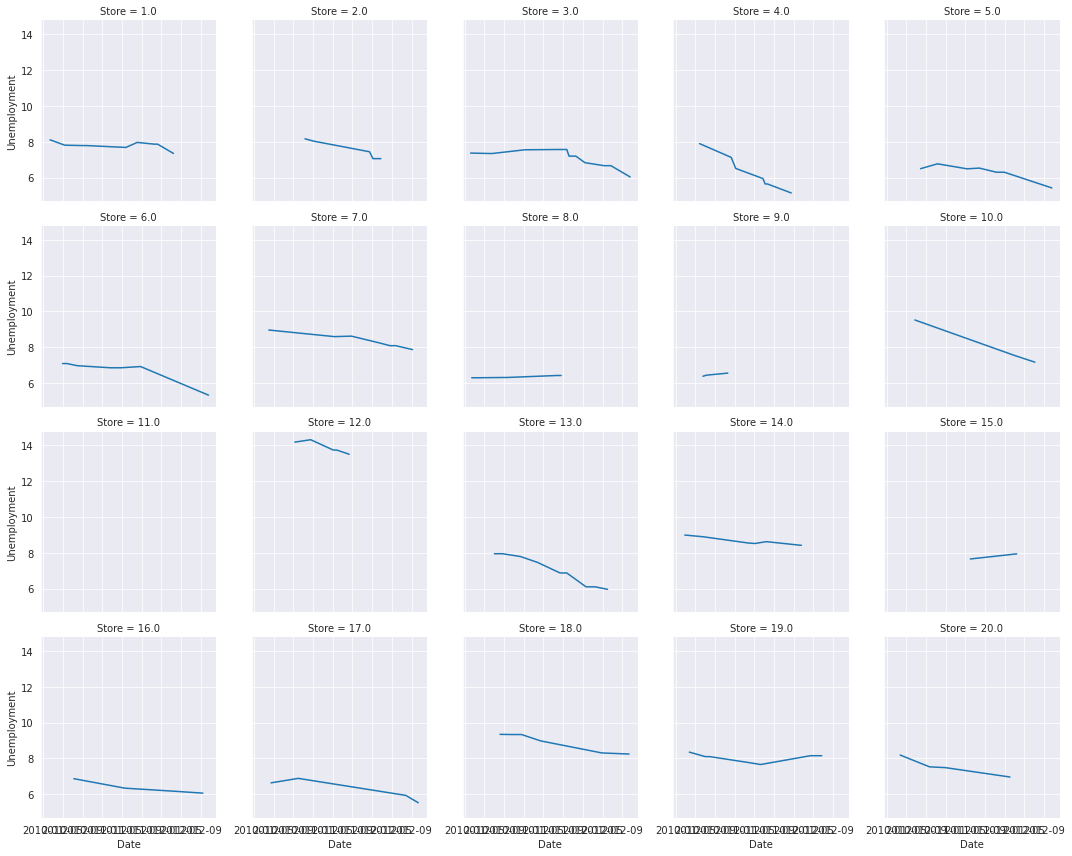

In [67]:
g = sns.FacetGrid(data, col='Store', col_wrap=5)
g.map(sns.lineplot, 'Date', 'Unemployment')

--> Median

In [73]:
data.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day',
       'dayofyear', 'week', 'dayofweek', 'fuel_price_outlier', 'CPI_outlier',
       'Unemployment_outlier'],
      dtype='object')

In [75]:
data_cat = data[['Date', 'Weekly_Sales', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day',
       'dayofyear', 'week', 'dayofweek']]
corr = data.corr()

<AxesSubplot:>

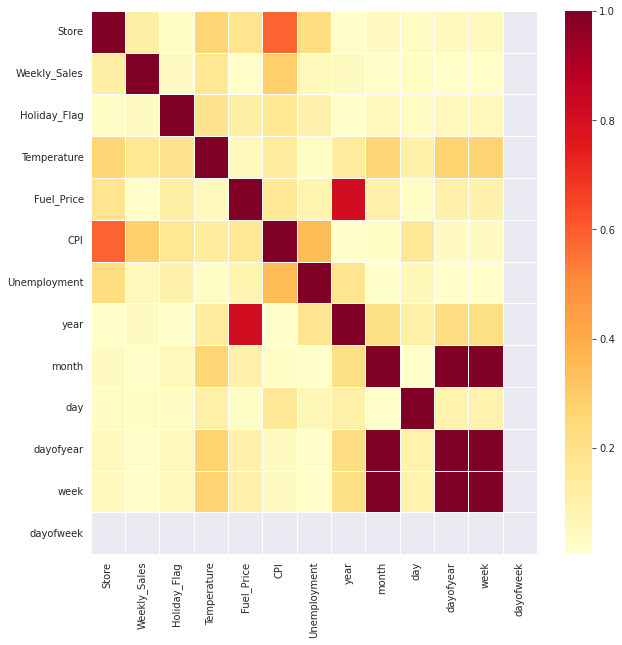

In [83]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr.abs(), linewidths=.5, cmap='YlOrRd')